In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load in selection function

In [7]:
# Apply Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr2_sf = CoGii.dr2_sf(version='modelAB',crowding=False)

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.290 s
  auxilliary:   4.287 s
          sf:   0.002 s
interpolator:   0.001 s


In [ ]:
ast_sf.s

In [23]:
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'
M = 85; C = 1; j=[-1,0,1,2,3,4]; lengthscale=0.3; nside=32
map_fname = f"chisquare_j{str(j).replace(' ','')}_nside{nside}_M{M}_C1_l0.3_results.h5"

M = 214; C = 1; jmax=4; lengthscale=0.3; nside=32
map_fname = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C1_l0.3_B2.0_ncores40mp_lbfgsb_scipy_results.h5"

M = 21; C = 1; jmax=4; lengthscale=0.3; nside=32
map_fname = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C1_l0.3_B2.0_ncores20mp_lbfgsb_scipy_results.h5"

ast_sf = chisel(map_fname=map_fname, nside=64, C=C, M=M, basis_options={'needlet':'chisquare', 'j':j, 'B':2.0, 'p':1.0, 'wavelet_tol':1e-2},
                       spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                       )

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4].h5
Spherical basis file loaded
t = 0.597 s
  auxilliary:   0.017 s
          sf:   0.000 s
interpolator:   0.580 s


# Apply selection function

In [28]:
m = np.arange(0.,23.,0.1)
l = np.random.rand(len(m))+2*np.pi
b = np.zeros(len(m)) + np.pi/2


In [29]:
gaiasf = sf_utils.apply_subgaiasf(l, b, m, dr2_sf=dr2_sf, get_prob=True)[1]

In [30]:
astsf = sf_utils.apply_subgaiasf(l, b, m, dr2_sf=dr2_sf, sub_sf=ast_sf)[1]

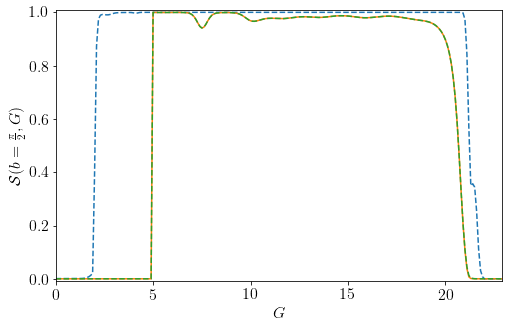

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

plt.plot(m, gaiasf, linestyle='--')
plt.plot(m, astsf*gaiasf)
plt.plot(m, astsf, linestyle='--')

plt.ylabel(r'$\mathcal{S}(b=\frac{\pi}{2}, G)$')

plt.xlabel(r'$G$')
plt.ylim(-0.01, 1.01); plt.xlim(m[0], m[-1])

plt.savefig(f'figs/gaia-dr2_ast-{map_fname}_SF_G.png', bbox_inches='tight', facecolor='w', transparent=False)